# Tutorial2: SPDE modes and low-rank projection
---
This tutorial demonstrates how modes of the underlying SPDE are computed using Randomized Subspace Iteration [1] (RSI). A low-rank GRF is attained by projection onto the top modes of the SPDE. 


References
---

[1] Halko, N., Martinsson, P.G. and Tropp, J.A.. Finding structure with randomness: Probabilistic algorithms
    for constructing approximate matrix decompositions. SIAM review, 53(2), pp.217-288. 2011.
    url: https://epubs.siam.org/doi/abs/10.1137/090771806

In [2]:
import pynoisy
import matplotlib.pyplot as plt

In [4]:
"""
Define a Solver object as the foward operator and sample a GRF (see Tutorial1 for more details)
num_solvers specifies the number of parallel solvers for simultanious forward 
computations with multiple input sources
"""
num_solvers = 5
diffusion = pynoisy.diffusion.general_xy(nx=64, ny=64)
advection = pynoisy.advection.general_xy(nx=64, ny=64)
solver = pynoisy.forward.HGRFSolver(advection, diffusion, nt=64, num_solvers=num_solvers)
grf = solver.run()

Setting solver seed to: 4814


In [5]:
"""
Compute the top modes using Randomized Subspace Iteration (RSI).
blocksize specifies the number of random vectors used and is close to the wanted subspace dimension.
maxiter specifies the number of subsequent RSI iterations.
"""
blocksize = 20
maxiter = 10
modes, residual = pynoisy.linalg.randomized_subspace(
    solver=solver, blocksize=blocksize, maxiter=maxiter, tol=5e-3
)

RSI converged with residual_mean = 0.472 ; residual_std = 0.067


<IPython.core.display.Javascript object>


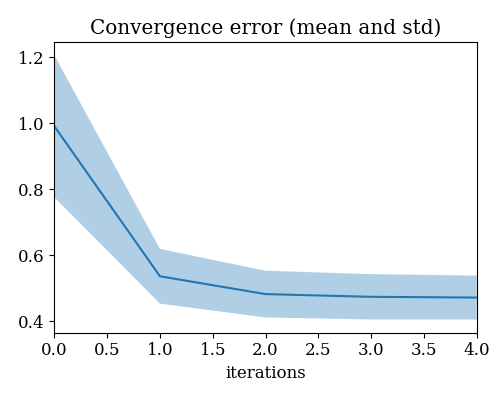

In [6]:
"""
Plot residual statistics computed on the test GRFs
"""
%matplotlib notebook
fig, ax = plt.subplots(1,1, figsize=(5,4))
pynoisy.visualization.plot_mean_std(residual['mean'], residual['std'], ax=ax)
ax.set_xlabel('iterations')
ax.set_title('Convergence error (mean and std)')
plt.tight_layout()

<IPython.core.display.Javascript object>


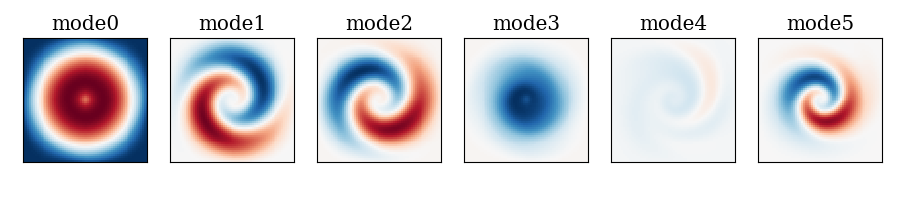

In [7]:
"""
Visualize the top 6 modes as an animated gif
"""
%matplotlib notebook
fig, axes = plt.subplots(1, 6, figsize=(9,2))
titles = ['mode{}'.format(i) for i in range(6)]
pynoisy.visualization.animate_synced(modes.eigenvectors, axes, titles=titles, add_colorbars=False)

In [8]:
"""
Compute a low-rank GRF as a projection onto the subspace spanned by the modes.
damp is the dampning factor when solving: `min ||Ax - b||^2 + damp^2 ||x||^2``,
"""
damp = 1.0
subspace = modes.eigenvalues * modes.eigenvectors
residual, projection, coefficients = pynoisy.linalg.projection_residual(
    grf, subspace, damp, return_projection=True, return_coefs=True
)

Traceback (most recent call last):
  File "/home/aviad/anaconda3/envs/eht/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/home/aviad/anaconda3/envs/eht/lib/python3.7/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


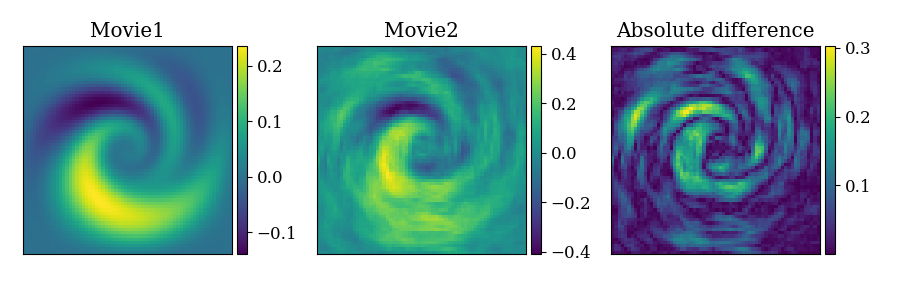

interactive(children=(IntSlider(value=31, description='frame', max=63), Output()), _dom_classes=('widget-inter…

In [9]:
"""
Visualize the projection in comparison to the full-rank GRF.
"""
%matplotlib notebook
pynoisy.visualization.slider_frame_comparison(projection, grf)

<IPython.core.display.Javascript object>


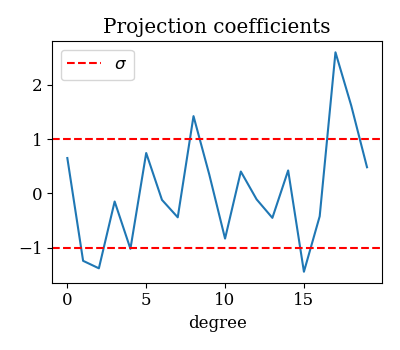

In [10]:
"""
Visualize the projection coefficients and the dampning factor. 
The coefficients are i.i.d. Gaussians with std that should equal the dampning factor.
"""
%matplotlib notebook
coefficients.plot(figsize=(4,3.5))
plt.axhline(damp, color='r', linestyle='--', label=r'$\sigma$')
plt.axhline(-damp, color='r', linestyle='--')
plt.legend()
plt.title('Projection coefficients')
plt.tight_layout()